In [2]:
import os
import cv2
import numpy as np
import random
import pathlib

import tensorflow as tf
import tensorflow.keras.layers

from tensorflow.keras.layers import TimeDistributed

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request

In [3]:
print(tf.__version__)

2.10.0


In [4]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [5]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [6]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [7]:
# Test Code
train_data_dir = pathlib.Path('/dcs/large/u1901447/videos/clips/data_35_frames/train')
val_data_dir = pathlib.Path('/dcs/large/u1901447/videos/clips/data_35_frames/val')
fg = FrameGenerator(train_data_dir, 25, training=True)

print(fg.class_names)
fg.class_ids_for_name

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

['CARRY', 'KICK_L', 'KICK_R', 'LINEOUT', 'MAUL', 'PASS_L', 'PASS_R', 'RUCK', 'SCRUM', 'TACKLE_D', 'TACKLE_D_D', 'TACKLE_S', 'TACKLE_S_D']
Shape: (25, 224, 224, 3)
Label: 7


2023-03-08 12:59:27.399675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 12:59:27.399826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcs/19/u1901447/year4/project/ruck_and_roll/venv3/lib/python3.9/site-packages/cv2/../../lib64:/local/java/postgresql/lib/:/local/java/postgresql/lib/
2023-03-08 12:59:27.400475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcs/19/u1901447/year4/project/ruck_and_roll/venv3/lib/python3.9/site-packages/cv2/../../lib64:/local/java/postgresql/lib/:/local/java/po

In [8]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_data_dir, 25, training=True),
                                          output_signature = output_signature)

# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_data_dir, 25),
                                        output_signature = output_signature)

In [9]:
# Test Code Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (25, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (25, 224, 224, 3)
Shape of validation labels: ()


In [10]:
print(train_labels)

tf.Tensor(0, shape=(), dtype=int16)


In [10]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [11]:
train_ds = train_ds.batch(8)
val_ds = val_ds.batch(8)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')
print(train_labels)

Shape of training set of frames: (8, 25, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 25, 224, 224, 3)
Shape of validation labels: (8,)
tf.Tensor([7 8 7 9 7 7 7 0], shape=(8,), dtype=int16)


In [12]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    # tf.keras.layers.Dense(4), #hmm
    tf.keras.layers.Dense(13),+

    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

print("finished compiling model")


history = model.fit(train_ds,
          epochs = 10, #try 40?
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

print("finished model fit")

finished compiling model
Epoch 1/10
88/88 [==============================] - 217s 2s/step - loss: 1.9873 - accuracy: 0.3333 - val_loss: 1.8113 - val_accuracy: 0.3422
Epoch 2/10
88/88 [==============================] - 204s 2s/step - loss: 1.8555 - accuracy: 0.3775 - val_loss: 1.7343 - val_accuracy: 0.3689
Epoch 3/10
88/88 [==============================] - 203s 2s/step - loss: 1.7833 - accuracy: 0.4074 - val_loss: 1.7212 - val_accuracy: 0.3556
Epoch 4/10
88/88 [==============================] - 202s 2s/step - loss: 1.7304 - accuracy: 0.4658 - val_loss: 1.6053 - val_accuracy: 0.5422
Epoch 5/10
88/88 [==============================] - 203s 2s/step - loss: 1.6626 - accuracy: 0.5370 - val_loss: 1.5755 - val_accuracy: 0.5911
Epoch 6/10
88/88 [==============================] - 203s 2s/step - loss: 1.6059 - accuracy: 0.5399 - val_loss: 1.5181 - val_accuracy: 0.5822
Epoch 7/10
88/88 [==============================] - 203s 2s/step - loss: 1.5727 - accuracy: 0.5755 - val_loss: 1.4855 - val_accur

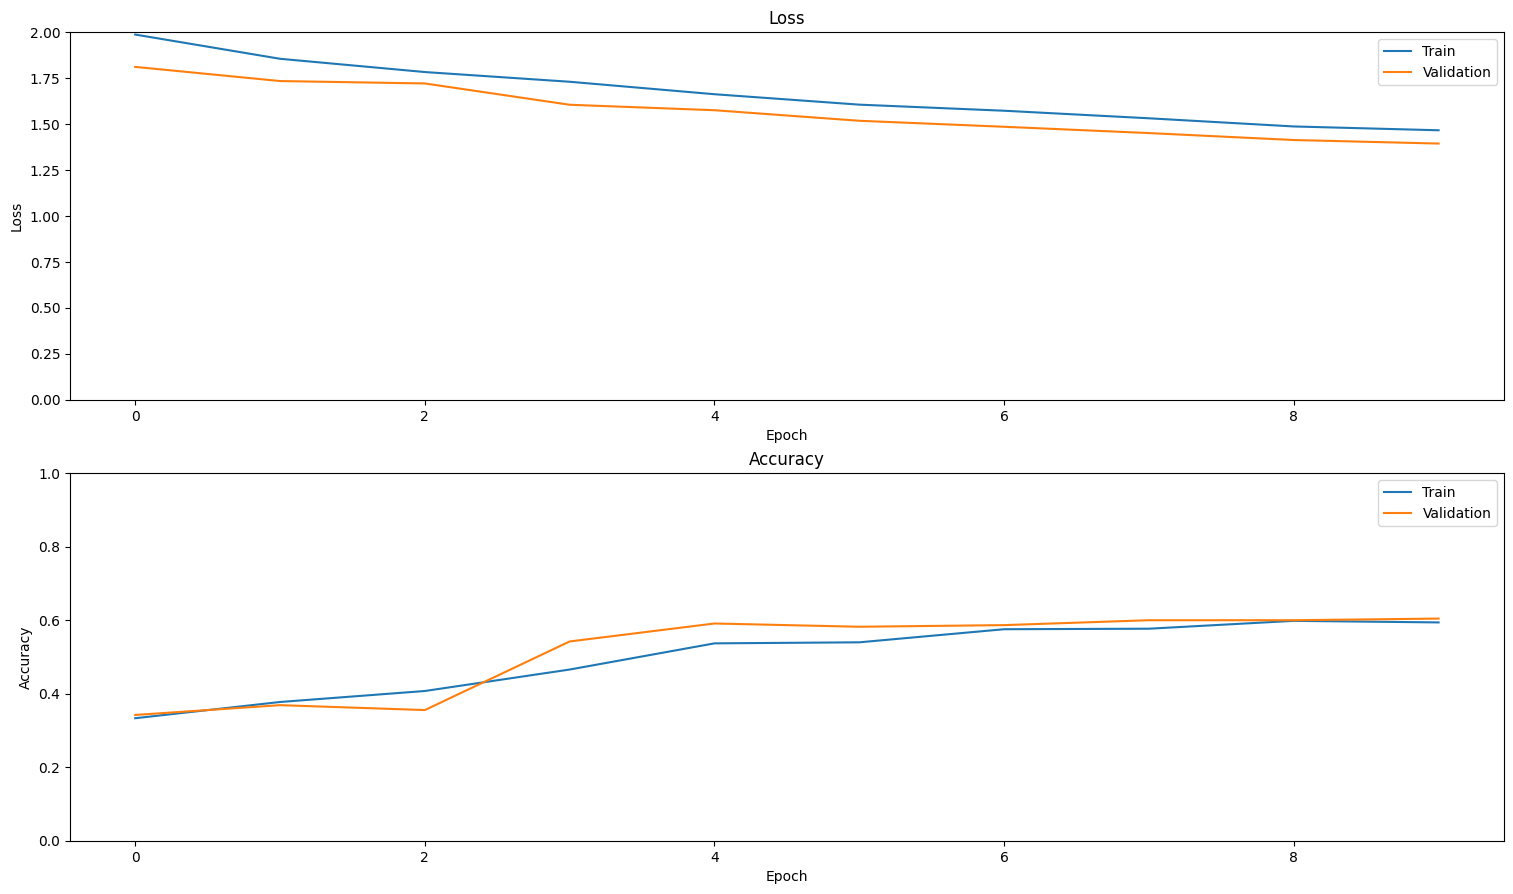

In [14]:
import matplotlib.pyplot as plt
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [15]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [16]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [17]:
fg = FrameGenerator(train_data_dir, 25, training=True)
labels = list(fg.class_ids_for_name.keys())


In [18]:
actual, predicted = get_actual_predicted_labels(train_ds)


88/88 [==============================] - 154s 2s/step


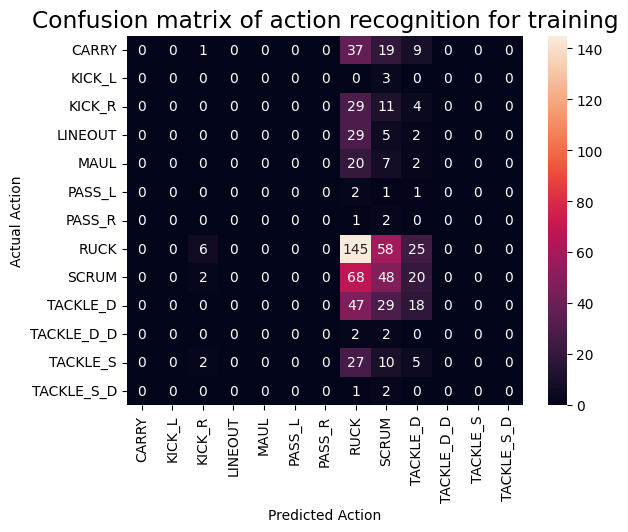

In [20]:
import seaborn as sns
plot_confusion_matrix(actual, predicted, labels, 'training')

29/29 [==============================] - 49s 2s/step


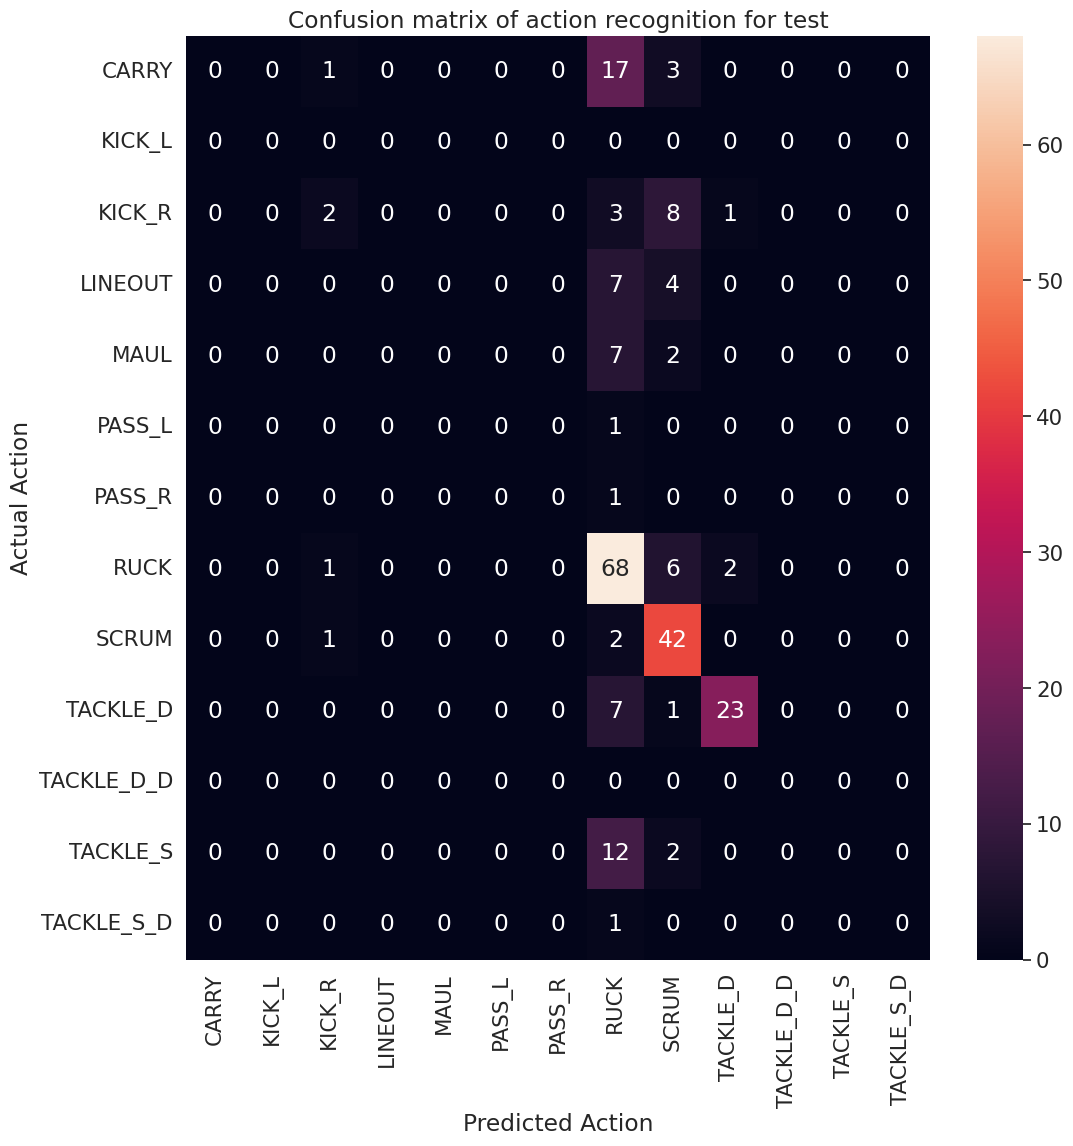

In [21]:
test_data_dir = pathlib.Path('/dcs/large/u1901447/videos/clips/data_35_frames/test')
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
n_frames = 25
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_data_dir, n_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(8)

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')